## Семинар 4: "Сверточные сети"

ФИО: 

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
import scipy
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

C:\Users\ADMIN\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    #np.convolve(signal,kenrel)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    res=[np.sum(signal[i:i+len(kernel)]*kernel[::-1]) for i in range(0,len(signal)-len(kernel)+1)]
    return res


Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

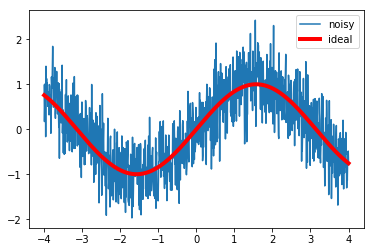

In [4]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [5]:
denoised_signal =convolve(noisy_signal,[0.2,0.2,0.2,0.2,0.2]) ### YOUR CODE HERE #####

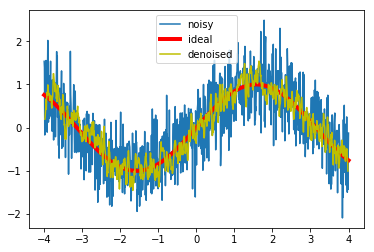

In [6]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal[:996], 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

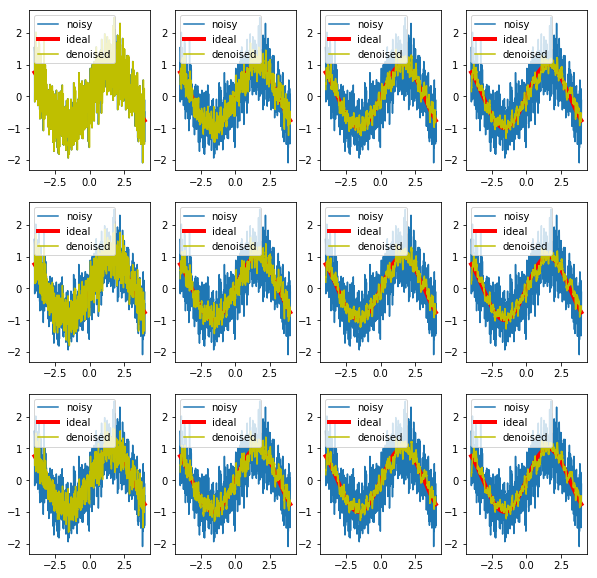

In [7]:
fig,ax=plt.subplots(3,4,figsize=(10,10))
j=0
k=0
for i in range(1,13):
    denoised_signal = convolve(noisy_signal,[1/i]*i)
    ax[k,j].plot(x, noisy_signal, label='noisy')
    ax[k,j].plot(x, signal, 'r', label='ideal', linewidth=4)
    ax[k,j].plot(x[2:-2], denoised_signal[:996], 'y', label='denoised')
    ax[k,j].legend(loc=0)
    k+=1
    if  i%3==0:
        j+=1
        k=0

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [10]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3,3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        
        self.linear_layers = nn.Sequential(nn.Linear(int(image_size/2*image_size/2*3), 10), nn.LogSoftmax())
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [5]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = Variable(torch.tensor(X))
                y = Variable(torch.tensor(y))
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                #print(loss_batch.data.item())
                losses.append(loss_batch.data.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = Variable(X)
                y = Variable(y)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

C:\Users\ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
C:\Users\ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\ADMIN\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0... (Train/Test) NLL: 0.841/0.362	Accuracy: 0.794/0.905
Epoch 1... (Train/Test) NLL: 0.321/0.273	Accuracy: 0.909/0.924
Epoch 2... (Train/Test) NLL: 0.263/0.236	Accuracy: 0.925/0.934
Epoch 3... (Train/Test) NLL: 0.232/0.213	Accuracy: 0.934/0.941
Epoch 4... (Train/Test) NLL: 0.210/0.195	Accuracy: 0.940/0.945


C:\Users\ADMIN\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


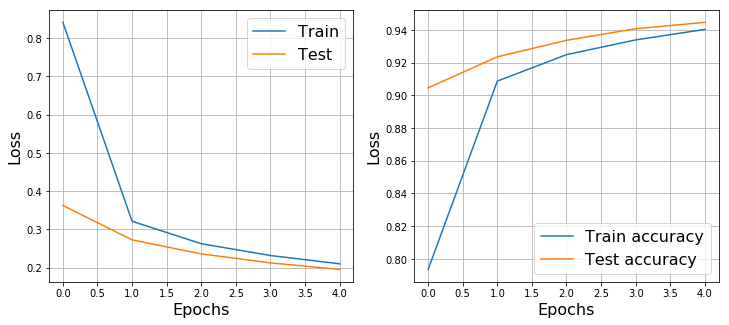

In [19]:
network = ConvClassifier()
train(network, 5, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax


In [4]:
image_size = 28
channels = 1
class ConvClassifier2(nn.Module):
    def __init__(self):
        super(ConvClassifier2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),nn.Conv2d(8, 16, 3, padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(int(image_size/2*image_size/2*16), 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

C:\Users\ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
C:\Users\ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\ADMIN\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0... (Train/Test) NLL: 0.465/0.220	Accuracy: 0.880/0.937
Epoch 1... (Train/Test) NLL: 0.190/0.140	Accuracy: 0.945/0.958
Epoch 2... (Train/Test) NLL: 0.128/0.096	Accuracy: 0.962/0.970
Epoch 3... (Train/Test) NLL: 0.098/0.078	Accuracy: 0.972/0.976
Epoch 4... (Train/Test) NLL: 0.082/0.066	Accuracy: 0.977/0.979


C:\Users\ADMIN\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


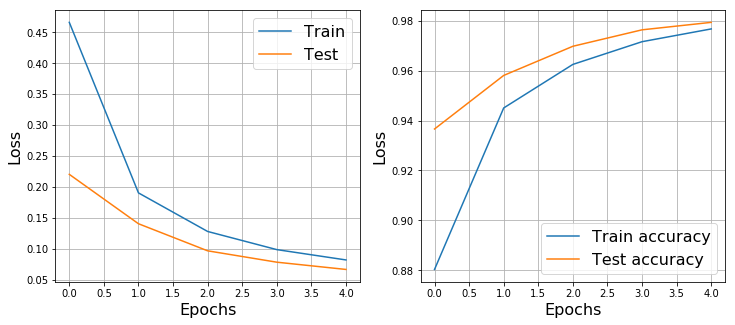

In [5]:
network = ConvClassifier2()
train(network, 5, 1e-4)

In [8]:
image_size = 28
channels = 1
class ConvClassifier3(nn.Module):
    def __init__(self):
        super(ConvClassifier3, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(),nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),nn.Conv2d(16, 32, 3, padding=1),nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(int(image_size/2*image_size/2)*32, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

C:\Users\ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
C:\Users\ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\ADMIN\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0... (Train/Test) NLL: 0.348/0.131	Accuracy: 0.905/0.962
Epoch 1... (Train/Test) NLL: 0.110/0.072	Accuracy: 0.968/0.978
Epoch 2... (Train/Test) NLL: 0.074/0.058	Accuracy: 0.978/0.981
Epoch 3... (Train/Test) NLL: 0.059/0.052	Accuracy: 0.982/0.983
Epoch 4... (Train/Test) NLL: 0.049/0.043	Accuracy: 0.985/0.985


C:\Users\ADMIN\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


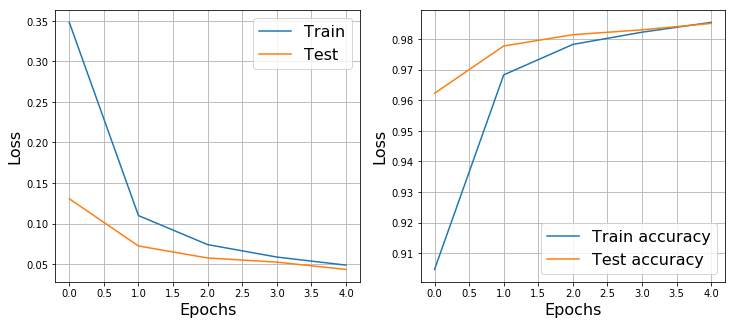

In [9]:
network = ConvClassifier3()
train(network, 5, 1e-4)